In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


# Lasso 
## Tuned with Optuna 

In [414]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)



lasso = Lasso(alpha = 0.00030733929099045147)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030733929099045147),
                                                                func =np.log, inverse_func=np.exp))])


lasso_pipe_SHAP = Pipeline(steps = [("Preprocess", preprocessor), ('lasso', lasso)])
                         
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

scores_SHAP = cross_val_score(lasso_pipe_SHAP, X, y, cv = kf, error_score='raise')


print('Lasso')

lasso_std = scores.std()
lasso_score = scores.mean()
print('score', lasso_score)
print('standard deviation', lasso_std)
print('      ')

lasso_pipe.fit(X,y)

lasso_predictions = lasso_pipe.predict(X)
print('predicted prices', lasso_predictions)

lasso_mae = mean_absolute_error(y, lasso_predictions)
print('Mean Absolute Error:', lasso_mae)

lasso_mpv = lasso_predictions.mean()
print ('Mean Predicted Home Value', lasso_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)
print('      ')

print('Lasso SHAP')
print('score', scores_SHAP.mean())
print('standard deviation', scores_SHAP.std())

Lasso
score 0.9508124989217249
standard deviation 0.004995040204432598
      
predicted prices [125417.29914791 130118.74949454 115891.54733895 ... 153058.38303178
 224554.74105895 223794.23727269]
Mean Absolute Error: 10280.912930379654
Mean Predicted Home Value 172914.8587998538
Mean  Home Value 173427.01285897984
      
Lasso SHAP
score 0.921047081957437
standard deviation 0.011056554252356082


In [519]:
pd.DataFrame(preprocessor.fit_transform(X))

0    1         2         3    4    5    6    7    8         9    \
0    -0.917342 -0.4 -0.331390 -0.355114  0.0  0.0  0.0  0.0  0.0  0.000000   
1    -0.604538  1.4 -1.232740 -1.273687  0.0  0.0  0.0  0.0  0.0 -0.458333   
2    -0.682334 -0.4 -0.440264 -0.815029  0.0  0.0  0.0  0.0  0.0 -0.458333   
3    -0.620746  0.4  0.440264 -0.290777  0.0  0.0  0.0  0.0  0.0 -0.833333   
4     0.393841  0.2  0.000000 -0.226941  0.0  0.0  0.0  0.0  0.0  1.166667   
...        ...  ...       ...       ...  ...  ...  ...  ...  ...       ...   
2328 -0.761750 -0.4  0.004661 -0.112842  0.0  0.0  0.0  0.0  0.0  0.000000   
2329  0.504052 -0.6  1.687008  1.100025  0.0  1.0  0.0  0.0  0.0 -1.125000   
2330  0.940032  0.8  0.528317 -0.762252  0.0  0.0 -2.0  0.0  0.0 -0.458333   
2331  0.680713  0.2 -0.005100 -0.119879  0.0  0.0  0.0  0.0  0.0  0.541667   
2332  0.792545  0.2  0.440264  0.063081  0.0  1.0  0.0  0.0  0.0  1.166667   

      ...  205  206  207  208  209  210  211  212  213  214  
0     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
1     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
2     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
3     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
4     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2328  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
2329  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
2330  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
2331  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  
2332  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  

[2333 rows x 215 columns]

## Lasso feature Importance 

In [524]:
lasso_pipe.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
lasso_regressor = lasso_pipe.named_steps['Regressor'].regressor_
coefficients = lasso_regressor.coef_
intercept = lasso_regressor.intercept_

# Get the feature names after preprocessing
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_lasso = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_lasso = feature_importance_lasso.sort_values(by='Importance', ascending=False)


feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('robust_scaler__', '', regex=False)
feature_importance_lasso['Feature'] = feature_importance_lasso['Feature'].str.replace('one-hot-encoder__', 'OHE__', regex=False)
print(intercept)
feature_importance_lasso.head()

11.834280030200357


Feature  Importance
0                   GrLivArea    0.162424
9                 OverallQual    0.113826
11                  YearBuilt    0.095025
75  OHE__Neighborhood_Crawfor    0.092007
91  OHE__Neighborhood_Somerst    0.057523

## Lasso SHAP
### One hot encoded categories left apart and log transformation not undone

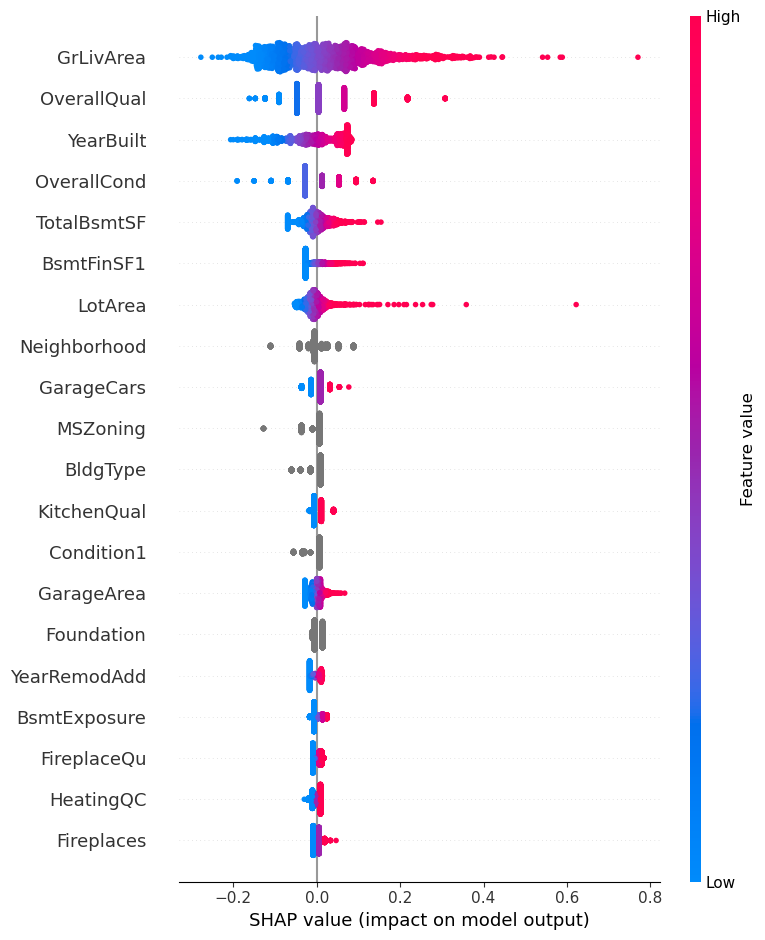

In [419]:
lasso_pipe.fit(X,y)

explainer_lasso_log = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lass_log = explainer_lasso_log(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_log = pd.DataFrame(shap_values_lass_log.values, columns=transformed_feature_names)

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_log[prefix] = shap_values_df_lasso_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_log.drop(columns=columns, inplace=True)

# Get rid of prefixes
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_log = shap.Explanation(shap_values_df_lasso_log.values, 
                       shap_values_lass_log.base_values,
                       X_new_order)

shap.summary_plot(exp_lasso_log)

In [400]:
np.exp(11.97)

157944.66039619152

## Lasso SHAP
### One hot encoded categories left apart

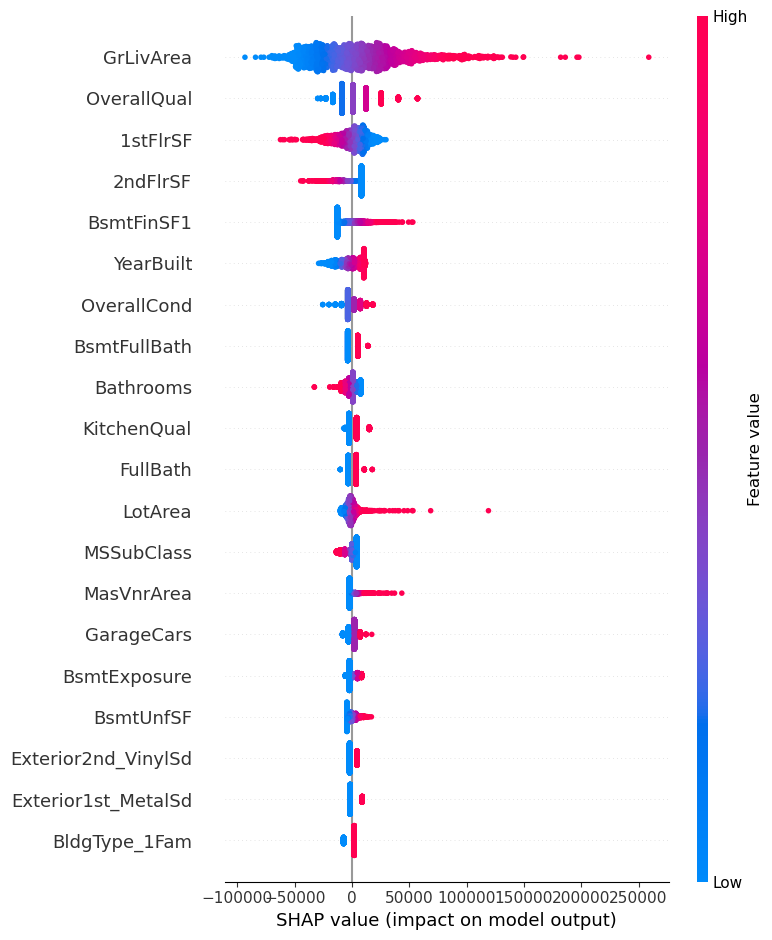

In [339]:
lasso_pipe_SHAP.fit(X,y)

explainer_lasso = shap.LinearExplainer(lasso_pipe_SHAP.named_steps['lasso'],
                          masker = lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lasso = explainer_lasso(lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)


# Get rid of prefixes
shap_values_df_lasso.columns = shap_values_df_lasso.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso.columns = shap_values_df_lasso.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

df_all = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
df_all.columns = shap_values_df_lasso.columns
df_all[numerical_columns] = X[numerical_columns]
df_all

# Create a shap.Explanation with scaled shap values and correct feature names 
exp_all_lasso = shap.Explanation(shap_values_df_lasso.values, 
                       shap_values_lasso.base_values,
                       df_all)

shap.summary_plot(exp_all_lasso)

## Lasso SHAP
### Features combined 

In [118]:
lasso_pipe_SHAP.fit(X,y)

explainer_lasso_comb = shap.LinearExplainer(lasso_pipe_SHAP.named_steps['lasso'],
                          masker = lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))
# Calculate SHAP values for the transformed test set
shap_values_lasso_comb = explainer_lasso(lasso_pipe_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_comb = pd.DataFrame(shap_values_lasso_comb.values, columns=transformed_feature_names)

# correct categorical prefixes so encoded variables can be combined"
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_comb[prefix] = shap_values_df_lasso_comb[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_comb.drop(columns=columns, inplace=True)

# find the base_value and use it to convert shap values back to dollars
# Use this to find the dollar value home with just that particular feature
# the subtract the bv of the home to see the exact value for that feature 
    
# Get rid of prefixes
shap_values_df_lasso_comb.columns = shap_values_df_lasso_comb.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_comb.columns = shap_values_df_lasso_comb.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)


# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso_comb = shap.Explanation(shap_values_df_lasso_comb.values, 
                       shap_values_lasso_comb.base_values,
                       X_new_order)

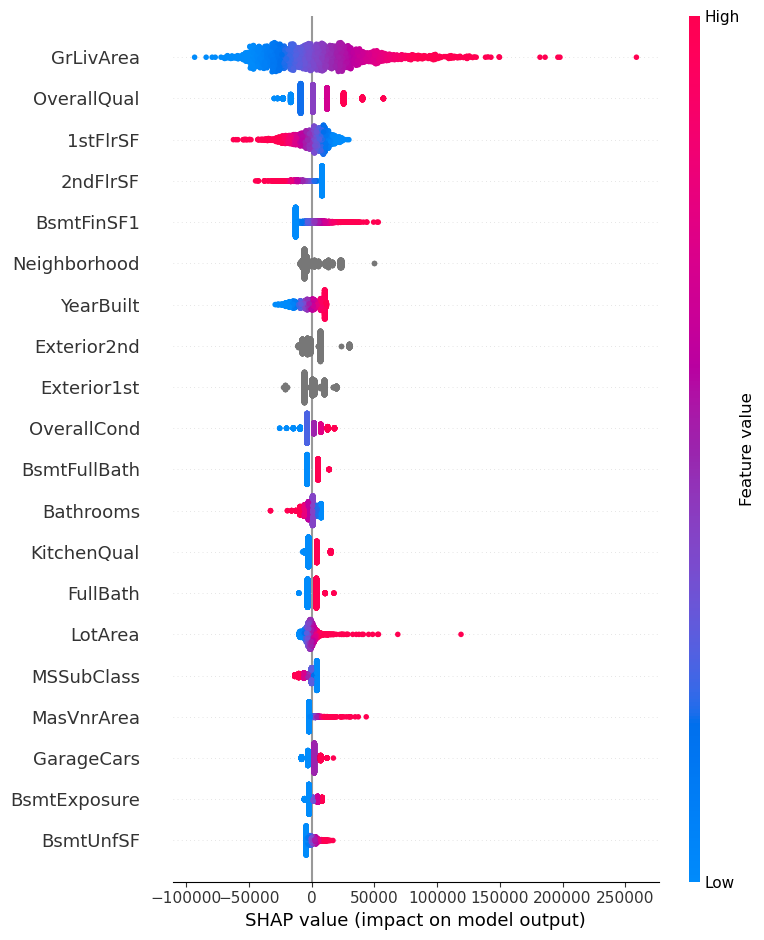

In [119]:
shap.summary_plot(exp_lasso_comb)

# XGB 
## Tuned with Optuna

In [144]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = None)
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb =  XGBRegressor(max_depth= 4,
                    learning_rate= 0.04643973848790804,
                    subsample= 0.5797329944770706,
                    colsample_bytree= 0.527504939004116,
                    n_estimators= 905,
                    min_child_weight= 3)


xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), 
                               ("Regressor", TransformedTargetRegressor(regressor =xgb,
                                                                          func =np.log, inverse_func=np.exp))])
xgb_pipe_OHE_SHAP = Pipeline(steps=[("Preprocess", preprocessor_OHE), ("XGB", xgb)])
                             

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')

scores_OHE_SHAP = cross_val_score(xgb_pipe_OHE_SHAP, X, y, cv = kf, error_score='raise')

scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
xgb_score = scores_OHE.mean()
xgb_std = scores_OHE.std()
print('score', xgb_score)
print('standard deviation', xgb_std)

xgb_pipe_OHE.fit(X,y)

xgb_pipe_OHE_SHAP.fit(X,y)

xgb_OHE_predictions = xgb_pipe_OHE.predict(X)
print('predicted prices', xgb_OHE_predictions)

xgb_OHE_mae = mean_absolute_error(y, xgb_OHE_predictions)
print('Mean Absolute Error:', xgb_OHE_mae)

xgb_OHE_mpv = xgb_OHE_predictions.mean()
print ('Mean Predicted Home Value', xgb_OHE_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())

xgb_pipe_O.fit(X,y)

xgb_O_predictions = xgb_pipe_O.predict(X)
print('predicted prices', xgb_O_predictions)

xgb_O_mae = mean_absolute_error(y, xgb_O_predictions)
print('Mean Absolute Error:', xgb_O_mae)

xgb_O_mpv = xgb_O_predictions.mean()
print ('Mean Predicted Home Value', xgb_O_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)



XGB OneHot
score 0.9532863998557761
standard deviation 0.004193143693708003
predicted prices [123622.27 137891.3  121283.25 ... 144853.23 219742.77 217241.7 ]
Mean Absolute Error: 4266.391641328226
Mean Predicted Home Value 173193.72
Mean  Home Value 173427.01285897984
         
XGB Ordinal
score 0.9517008137105984
standard deviation 0.0034580565604390907
predicted prices [122192.01 136081.95 122892.52 ... 144499.02 223449.78 214595.14]
Mean Absolute Error: 3962.2353109596015
Mean Predicted Home Value 173427.27
Mean  Home Value 173427.01285897984


## XGB feature imprtance 
### One hot encoder

In [121]:
# Extracting feature importances
# Get the coefficients from the Lasso model
xgb_regressor =xgb_pipe_OHE.named_steps['Regressor'].regressor_
coefficients = xgb_regressor.feature_importances_

# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_oh = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': coefficients})

# Sort the DataFrame by importance
feature_importance_xgb_oh = feature_importance_xgb_oh.sort_values(by='Importance', ascending=False)


feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_oh['Feature'] = feature_importance_xgb_oh['Feature'].str.replace('encoder__', 'OHE__', regex=False)
feature_importance_xgb_oh.head()


Feature  Importance
9   OverallQual    0.078207
39  FireplaceQu    0.050489
41   GarageCars    0.045544
44   GarageCond    0.045198
14    ExterQual    0.044847

## XGB feature imprtance 
### Ordinal encoder

In [122]:
xgb_pipe_OHE_SHAP.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_OHE_SHAP.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(5)

Feature  Importance
9   OverallQual    0.181990
41   GarageCars    0.123966
14    ExterQual    0.116161
35  KitchenQual    0.059732
54    Bathrooms    0.049241

In [123]:
xgb_pipe_O.fit(X, y)

# Extracting feature importances
# Get the coefficients from the Lasso model
#xgb_regressor = xgb_pipe.named_steps['Regressor'].regressor_
#feature_imp = xgb_regressor.feature_importances_
feature_imp = xgb_pipe_O.named_steps['XGB'].feature_importances_
# Get the feature names after preprocessing
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Combine the feature names and coefficients into a DataFrame
feature_importance_xgb_o = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_imp})

# Sort the DataFrame by importance
feature_importance_xgb_o = feature_importance_xgb_o.sort_values(by='Importance', ascending=False)

feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('standard_scaler__', '', regex=False)
feature_importance_xgb_o['Feature'] = feature_importance_xgb_o['Feature'].str.replace('encoder__', '', regex=False)

feature_importance_xgb_o.head(5)

Feature  Importance
14    ExterQual    0.285339
9   OverallQual    0.178795
41   GarageCars    0.117365
35  KitchenQual    0.059092
16     BsmtQual    0.036490

## XGB SHAP
### One hot encoder...Target transformation left as log dollars

In [124]:
xgb_pipe_OHE.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb = explainer_xgb(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

 99%|===================| 2308/2333 [00:25<00:00]        

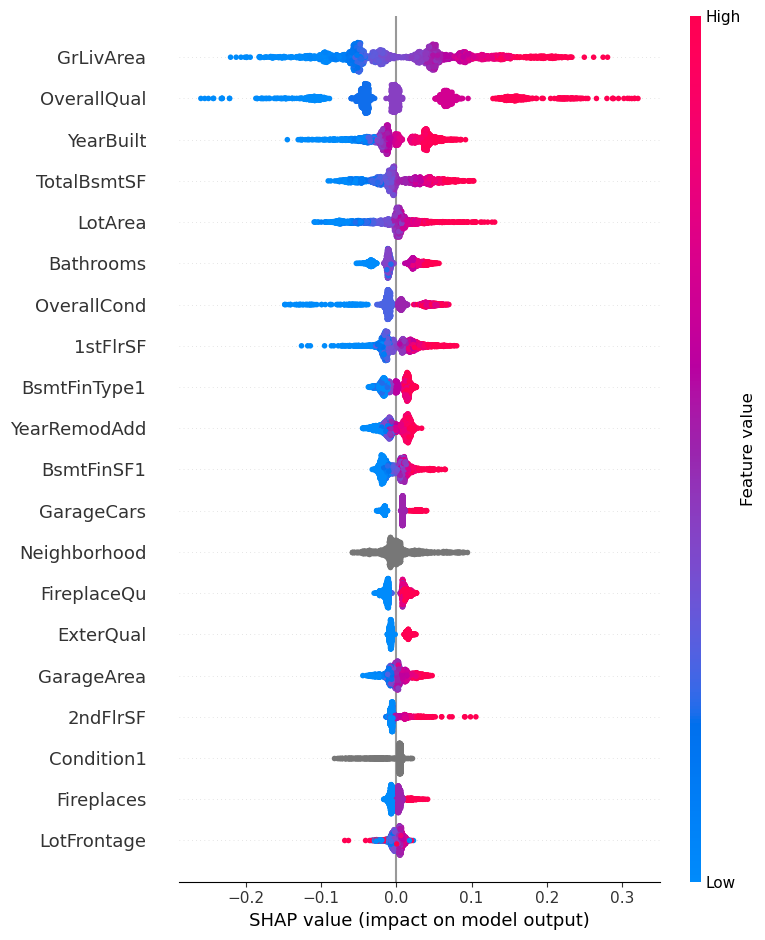

In [125]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_log = pd.DataFrame(shap_values_xgb.values, 
                                      columns=transformed_feature_names)
    
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["encoder__" + word for word in categorical_prefixes]

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_log[prefix] = shap_values_df_xgb_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_log.drop(columns=columns, inplace=True)
# Get rid of prefixes
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

exp_xgb_log = shap.Explanation(shap_values_df_xgb_log.values, 
                       shap_values_xgb.base_values,
                       X_new_order)

shap.summary_plot(exp_xgb_log, max_display= 20)

## XGB SHAP
### One hot encoder

In [126]:
xgb_pipe_OHE_SHAP.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb_ohe = shap.Explainer(xgb_pipe_OHE_SHAP.named_steps['XGB'],
                          masker = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_ohe = explainer_xgb_ohe(xgb_pipe_OHE_SHAP.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE_SHAP.named_steps['Preprocess'].get_feature_names_out()

 96%|=================== | 2249/2333 [00:24<00:00]       

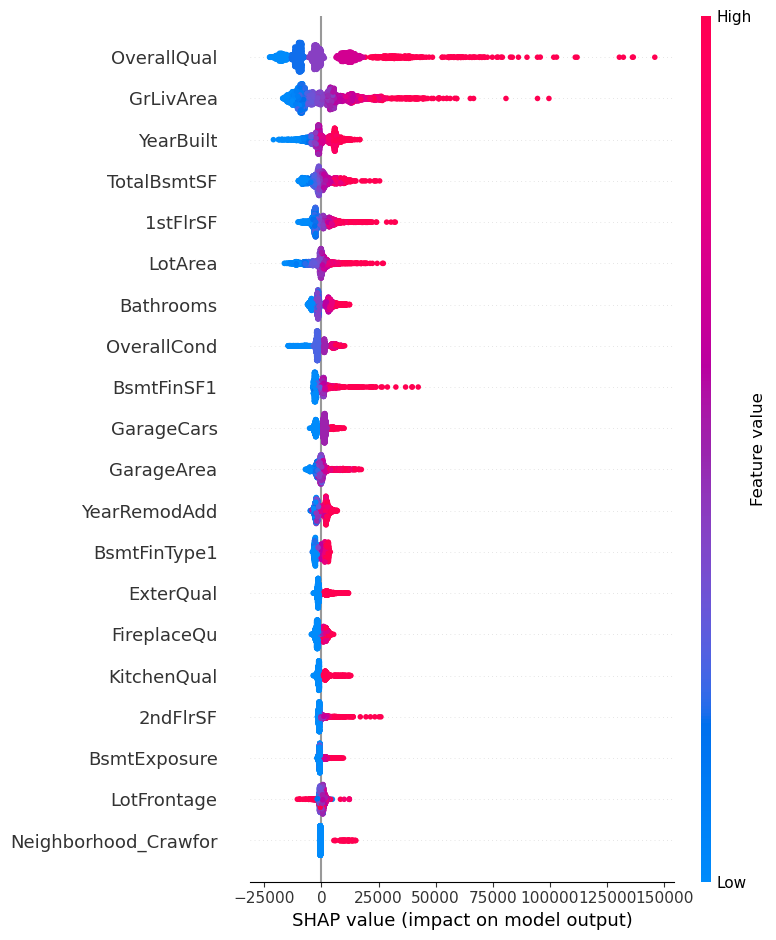

In [127]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_ohe = pd.DataFrame(shap_values_xgb_ohe.values, columns=transformed_feature_names)
    
# Get rid of prefixes
shap_values_df_xgb_ohe.columns = shap_values_df_xgb_ohe.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_ohe.columns = shap_values_df_xgb_ohe.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)
# Create explanation varaible using SHAP values, base values, and original values 
exp_all_xgb_ohe = shap.Explanation(shap_values_df_xgb_ohe.values, 
                       shap_values_xgb_ohe.base_values,
                       df_all)

shap.summary_plot(exp_all_xgb_ohe, max_display= 20)

# XGB SHAP
## One hot encoded categorical features combines 

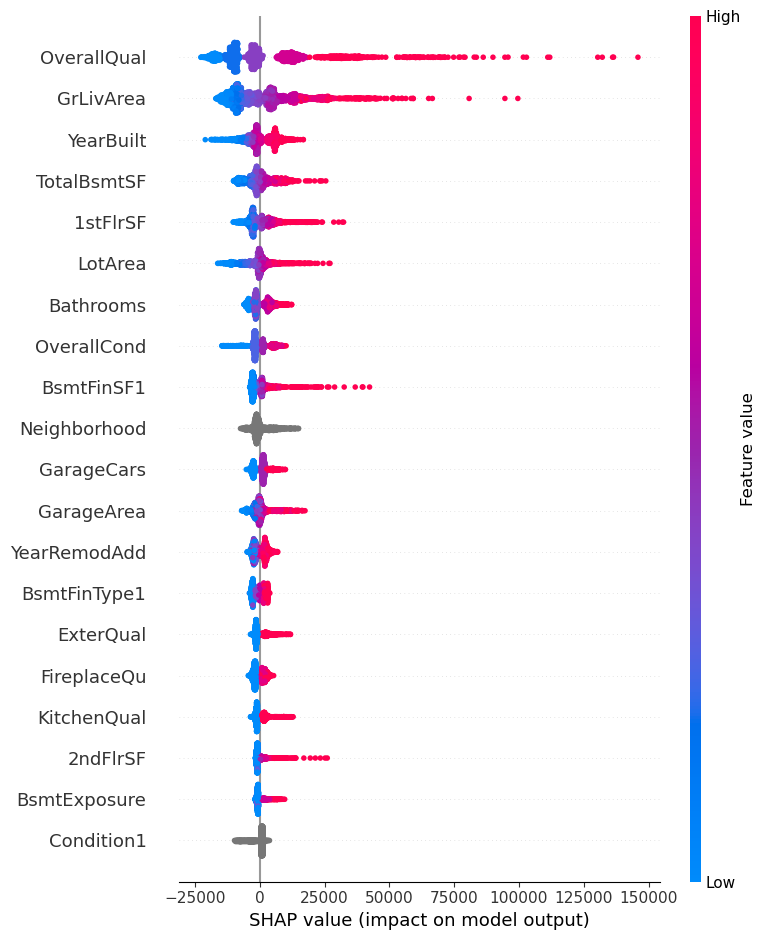

In [128]:
# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_ohe_comb = pd.DataFrame(shap_values_xgb_ohe.values, columns=transformed_feature_names)

#correct categorical prefixes so encoded variables can be combined"

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_ohe_comb[prefix] = shap_values_df_xgb_ohe_comb[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_ohe_comb.drop(columns=columns, inplace=True)


# Get rid of prefixes
shap_values_df_xgb_ohe_comb.columns = shap_values_df_xgb_ohe_comb.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_ohe_comb.columns = shap_values_df_xgb_ohe_comb.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

exp_comb_xgb_ohe = shap.Explanation(shap_values_df_xgb_ohe_comb.values, 
                       shap_values_xgb_ohe.base_values,
                       X_new_order)

shap.summary_plot(exp_comb_xgb_ohe, max_display= 20)

## XGB SHAP
### Ordinal encoder

In [129]:
xgb_pipe_O.fit(X,y)

explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)


 98%|===================| 2289/2333 [00:25<00:00]        

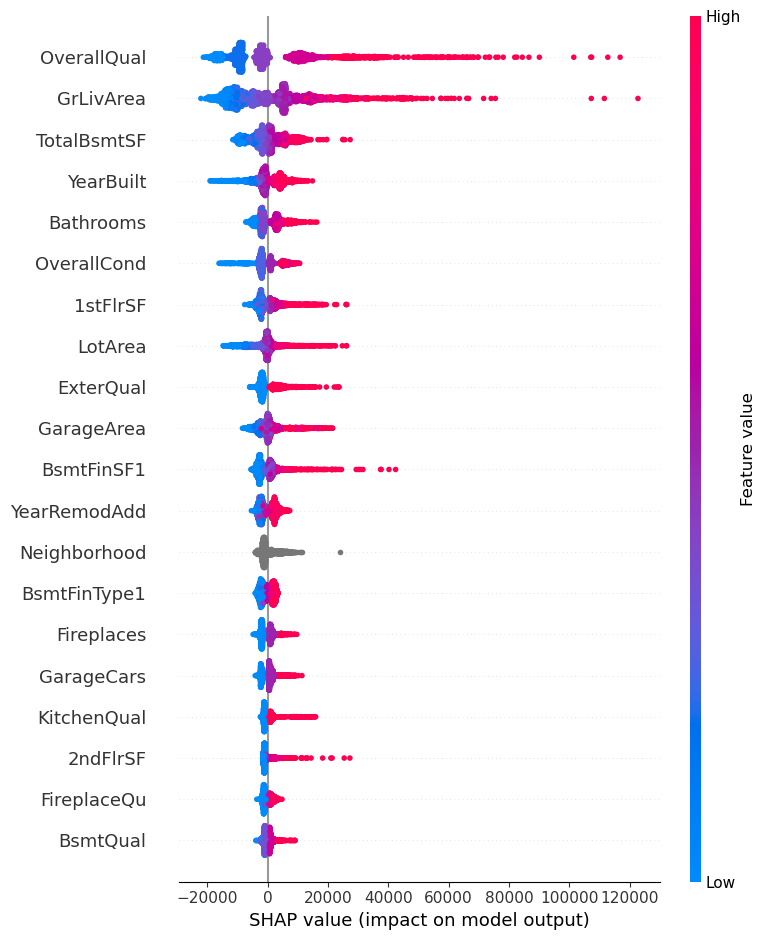

In [130]:
exp_all_xgb_o = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_new_order
                         )

shap.summary_plot(exp_all_xgb_o, max_display= 20)


In [513]:
xgb_O_predictions[334]

94041.71

In [515]:
xgb_OHE_predictions[334]

93531.4

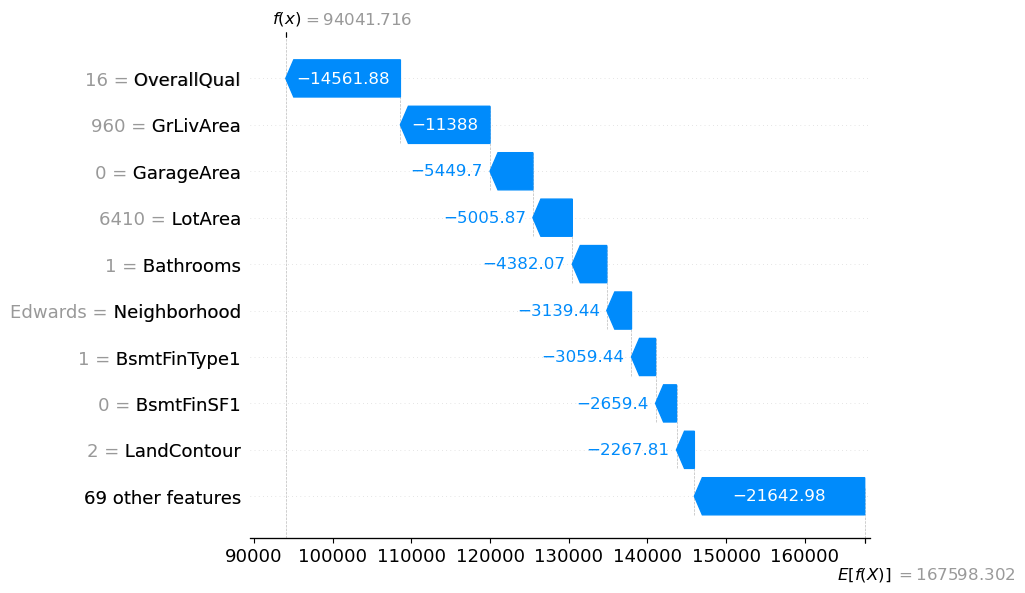

In [514]:
shap.waterfall_plot(exp_all_xgb_o[334])

# Compare Lasso to XGB

In [131]:
df_predictions = df_normal_quality.copy()
df_predictions['Lasso'] = lasso_predictions
df_predictions['error_Lasso'] = df_predictions.SalePrice - df_predictions.Lasso
df_predictions['xgb'] = xgb_OHE_predictions
df_predictions['error_xgb'] = df_predictions.SalePrice - df_predictions.xgb
df_predictions[['SalePrice', 'Lasso',  'error_Lasso', 'xgb','error_xgb']]

SalePrice          Lasso   error_Lasso            xgb     error_xgb
0        126000  125417.299148    582.700852  123622.273438   2377.726562
1        139500  130118.749495   9381.250505  137891.296875   1608.703125
2        124900  115891.547339   9008.452661  121283.250000   3616.750000
3        114000  105123.287031   8876.712969  110579.406250   3420.593750
4        227000  223707.350576   3292.649424  212743.046875  14256.953125
...         ...            ...           ...            ...           ...
2328     121000  107056.493708  13943.506292  118744.179688   2255.820312
2329     139600  122895.059269  16704.940731  137730.687500   1869.312500
2330     145000  153058.383032  -8058.383032  144853.234375    146.765625
2331     217500  224554.741059  -7054.741059  219742.765625  -2242.765625
2332     215000  223794.237273  -8794.237273  217241.703125  -2241.703125

[2333 rows x 5 columns]

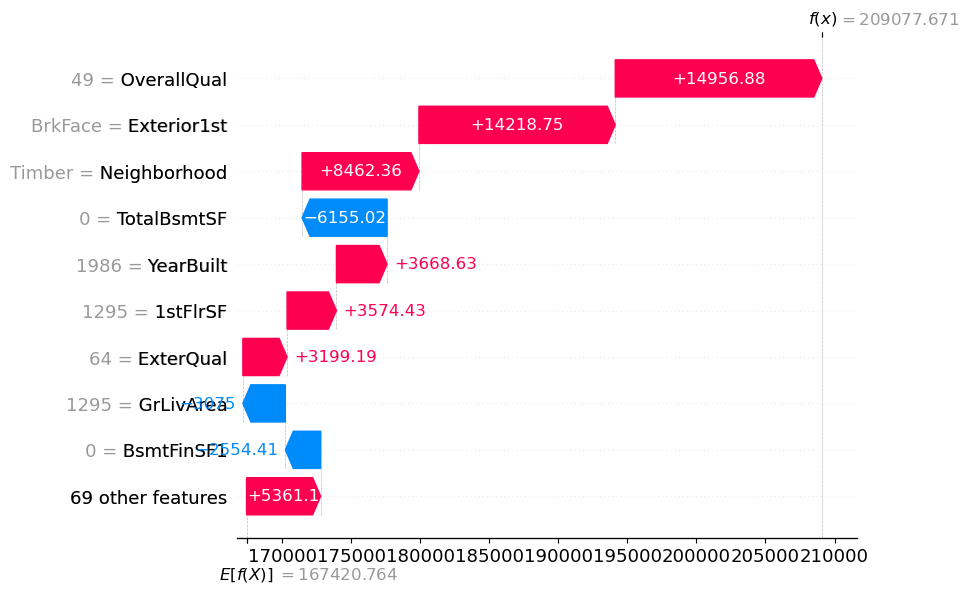

In [110]:
shap.waterfall_plot(exp_comb_xgb_ohe[530], max_display= 10)

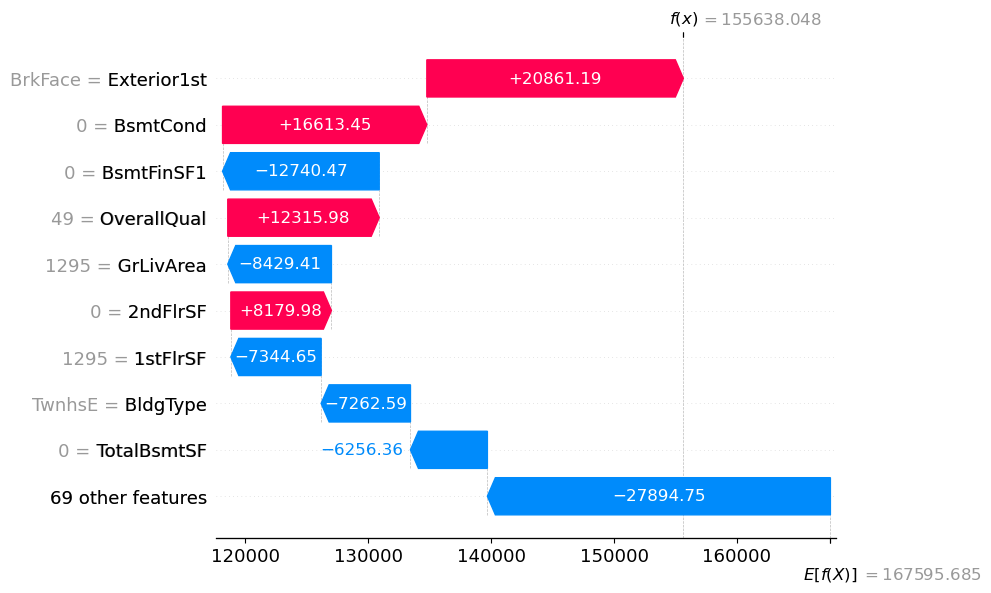

In [111]:
shap.waterfall_plot(exp_lasso_comb[530], max_display= 10)

In [143]:
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - lasso_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>R2:{lasso_score:.4f} / std: {lasso_std:.4f} / Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)',
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))


fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0,
    height = 700, 
    width = 700
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)
# Show plot
fig.show()

fig.write_image("images/lasso_error.png")

In [145]:
# xgb_predictions = xgb_pipe_OHE.predict(X)
# xgb_mae = mean_absolute_error(y, xgb_predictions)
import plotly.express as px
import pandas as pd

# Assuming X is a DataFrame and y, predictions are Series
# Combine y and predictions into a DataFrame for easy handling
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - xgb_OHE_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>R2: {xgb_score:.4f} / std: {xgb_std:.4f} / Mean Absolute Error: ${xgb_OHE_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)', 
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0,
    height = 700, 
    width = 700
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)

# Show plot
fig.show()

fig.write_image("images/xgb_error.png")

In [134]:
# fig.show()
neighborhood_counts = X['Neighborhood'].value_counts()

# Filter the data to include only neighborhoods with more than 10 homes
filtered_neighborhoods = neighborhood_counts[neighborhood_counts > 5].index
filtered_X = X[X['Neighborhood'].isin(filtered_neighborhoods)]

import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.loc[filtered_X.index].Neighborhood,
    y=shap_values_df_xgb_ohe_comb.loc[filtered_X.index].Neighborhood,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.loc[filtered_X.index].Neighborhood,
    y= shap_values_df_lasso_comb.loc[filtered_X.index].Neighborhood,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

#fig.write_image("images/neighborhood_SHAP.png")

In [135]:
X.loc[X.Neighborhood == 'NridgHt']

GrLivArea  MSSubClass MSZoning  LotFrontage  LotArea Street  Alley  \
9          1342         120       RL     48.00000     6240   Pave    0.0   
25         2046          20       RL    105.00000    15431   Pave    0.0   
51         2470          20       RL    106.00000    12720   Pave    0.0   
53         1324         120       RL     48.00000     6240   Pave    0.0   
119        1358         120       RL     47.00000     6904   Pave    0.0   
...         ...         ...      ...          ...      ...    ...    ...   
2217       1405         120       RL     24.83081     3136   Pave    0.0   
2240       1535          20       RL     70.00000    10171   Pave    0.0   
2251       2296          60       RL     97.00000    13478   Pave    0.0   
2268       1718          20       RL     96.00000    12456   Pave    0.0   
2275       1717          20       RL     87.00000    11146   Pave    0.0   

      LotShape  LandContour  Utilities  ... 3SsnPorch  ScreenPorch PoolYN  \
9            1            4          4  ...         0            0     no   
25           1            4          4  ...         0          175     no   
51           1            2          4  ...         0          216    yes   
53           1            4          4  ...         0            0     no   
119          2            4          4  ...         0            0     no   
...        ...          ...        ...  ...       ...          ...    ...   
2217         2            4          4  ...         0            0     no   
2240         2            4          4  ...         0            0     no   
2251         2            4          4  ...         0            0     no   
2268         1            4          4  ...         0            0     no   
2275         2            4          4  ...         0            0     no   

     PoolQC Fence MoSold YrSold  SaleType  SaleCondition  Bathrooms  
9       0.0    NO      2   2008       WD          Normal        2.0  
25      0.0    NO      8   2007       WD          Normal        3.5  
51      5.0    NO      2   2008       WD          Normal        3.5  
53      0.0    NO     12   2009       WD          Normal        3.0  
119     0.0    NO      8   2009       WD          Normal        2.0  
...     ...   ...    ...    ...       ...            ...        ...  
2217    0.0    NO      3   2006       WD          Normal        2.0  
2240    0.0    NO      3   2010       WD          Normal        2.0  
2251    0.0    NO      6   2009     ConLI         Normal        3.5  
2268    0.0    NO      7   2009       WD          Normal        3.0  
2275    0.0    NO      7   2009       WD          Normal        2.0  

[97 rows x 78 columns]

In [139]:
y[25]

450000

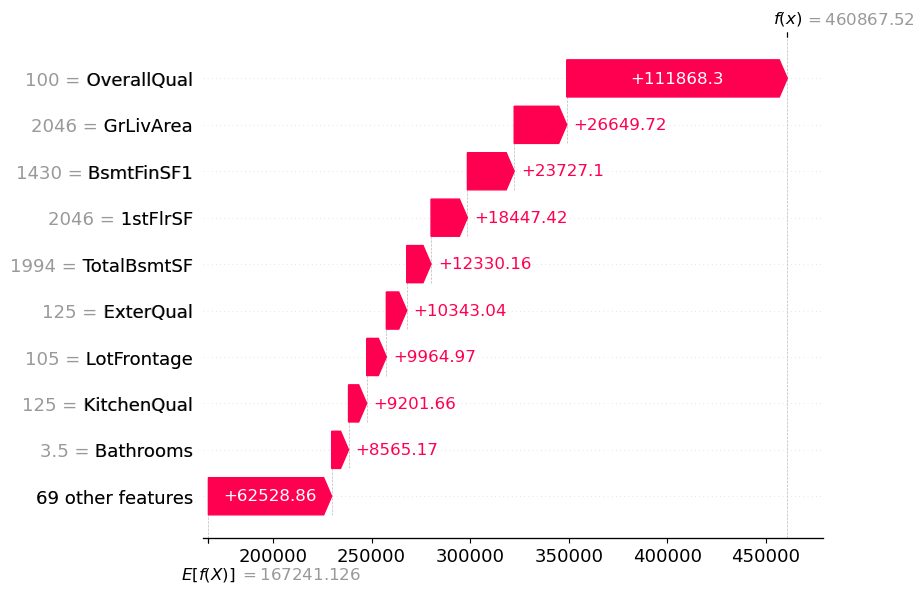

In [340]:
shap.waterfall_plot(exp_comb_xgb_ohe[25])

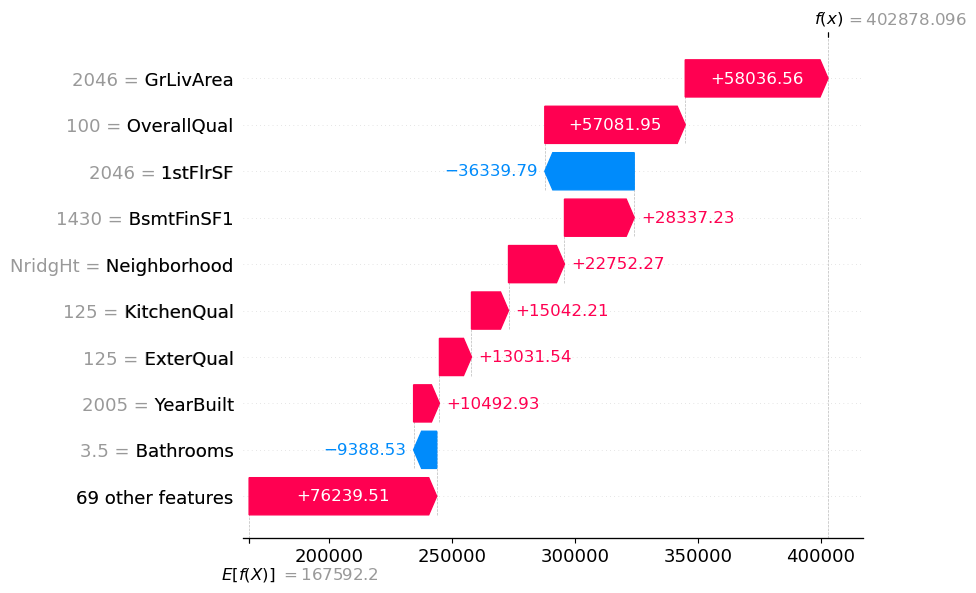

In [341]:
shap.waterfall_plot(exp_lasso_comb[25])

In [68]:
X.Neighborhood.value_counts()

Neighborhood
NAmes      391
CollgCr    226
OldTown    199
Edwards    148
Sawyer     132
Gilbert    128
NWAmes     112
Somerst    112
SawyerW    103
Mitchel     98
NridgHt     97
BrkSide     95
Crawfor     75
IDOTRR      65
NoRidge     61
Timber      48
SWISU       38
MeadowV     34
StoneBr     33
ClearCr     31
BrDale      26
NPkVill     22
Veenker     20
Blmngtn     19
Blueste     10
Greens       8
GrnHill      1
Landmrk      1
Name: count, dtype: int64

In [69]:
X.loc[X.Neighborhood == 'GrnHill']

GrLivArea  MSSubClass MSZoning  LotFrontage  LotArea Street  Alley  \
530       1295         120       RM    65.236303     8239   Pave    0.0   

     LotShape  LandContour  Utilities  ... 3SsnPorch  ScreenPorch PoolYN  \
530         2            4          4  ...         0            0     no   

    PoolQC Fence MoSold YrSold  SaleType  SaleCondition  Bathrooms  
530    0.0    NO     11   2006       WD          Normal        2.0  

[1 rows x 78 columns]

In [70]:
y[530]

230000

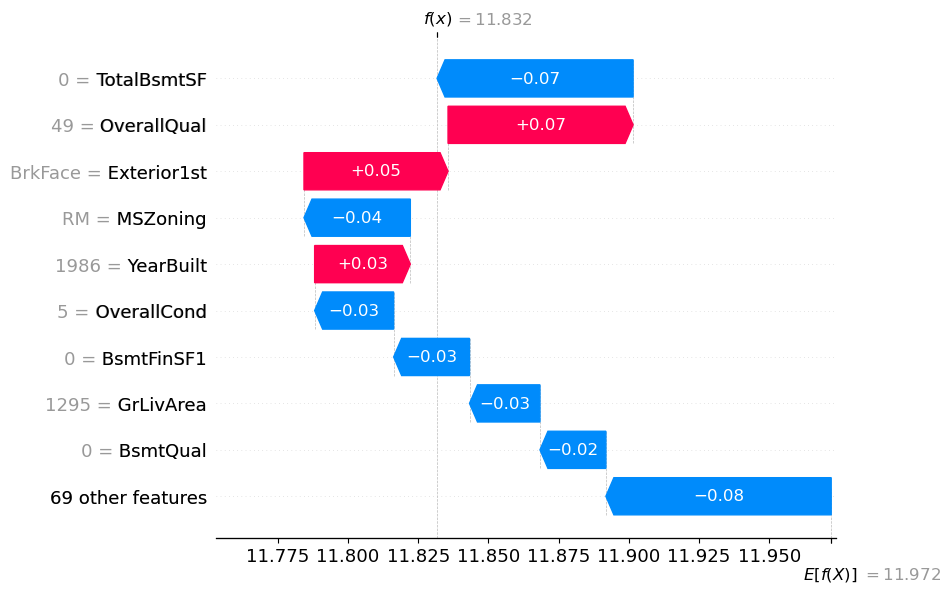

In [74]:
shap.waterfall_plot(exp_lasso_log[530], max_display= 10)

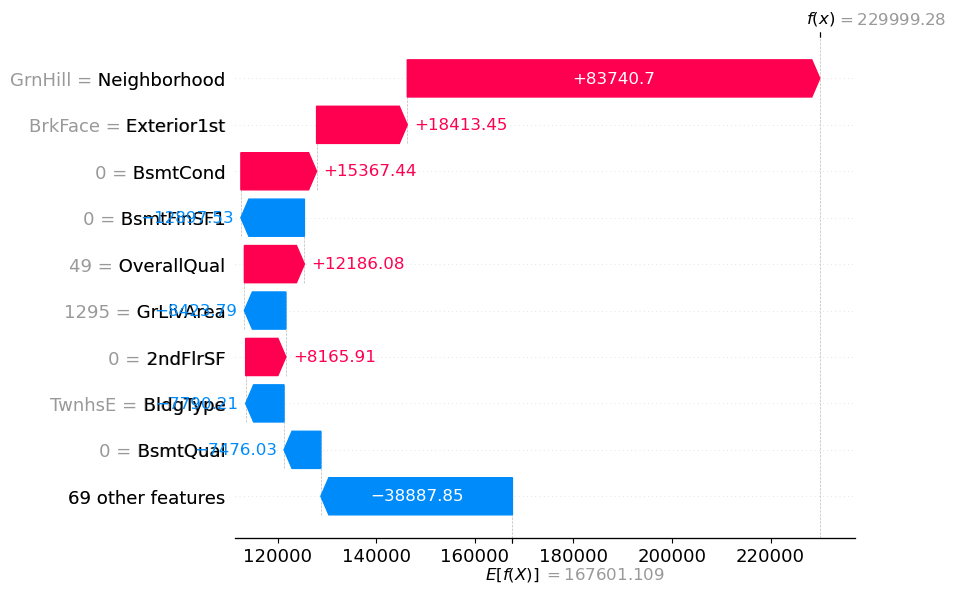

In [71]:
shap.waterfall_plot(exp_lasso_comb[530], max_display= 10)

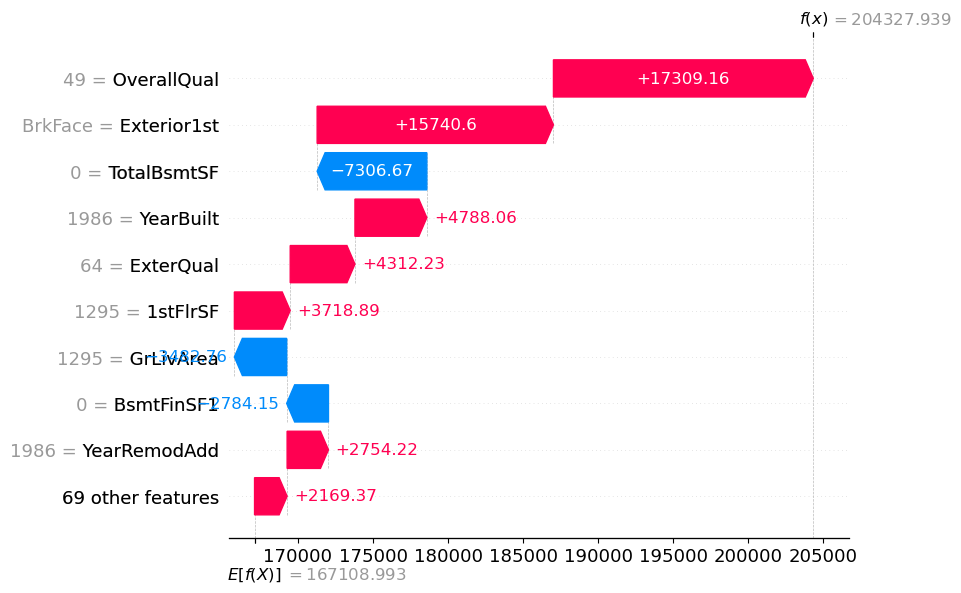

In [72]:
shap.waterfall_plot(exp_comb_xgb_ohe[530], max_display= 10)

(array([ 1.,  1.,  1., 12.,  5., 13.,  4.,  9.,  5.,  2.,  1.,  4.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([190000.        , 208833.33333333, 227666.66666667, 246500.        ,
        265333.33333333, 284166.66666667, 303000.        , 321833.33333333,
        340666.66666667, 359500.        , 378333.33333333, 397166.66666667,
        416000.        , 434833.33333333, 453666.66666667, 472500.        ,
        491333.33333333, 510166.66666667, 529000.        , 547833.33333333,
        566666.66666667, 585500.        , 604333.33333333, 623166.66666667,
        642000.        , 660833.33333333, 679666.66666667, 698500.        ,
        717333.33333333, 736166.66666667, 755000.        ]),
 <BarContainer object of 30 artists>)

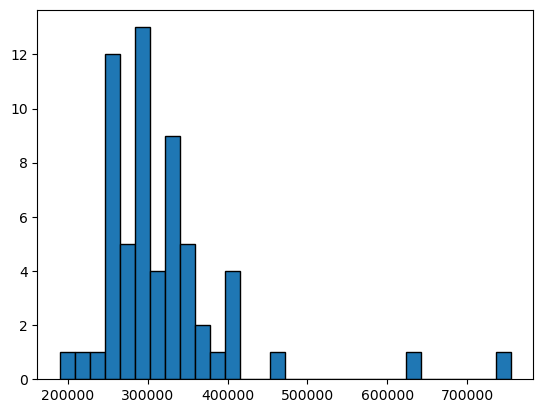

In [164]:
plt.hist(df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].SalePrice, bins=30, edgecolor='black')

(array([1., 0., 0., 1., 1., 3., 6., 6., 6., 7., 5., 4., 6., 5., 2., 1., 4.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([12.15477935, 12.20076914, 12.24675893, 12.29274872, 12.33873851,
        12.3847283 , 12.43071809, 12.47670788, 12.52269767, 12.56868745,
        12.61467724, 12.66066703, 12.70665682, 12.75264661, 12.7986364 ,
        12.84462619, 12.89061598, 12.93660577, 12.98259556, 13.02858535,
        13.07457514, 13.12056493, 13.16655471, 13.2125445 , 13.25853429,
        13.30452408, 13.35051387, 13.39650366, 13.44249345, 13.48848324,
        13.53447303]),
 <BarContainer object of 30 artists>)

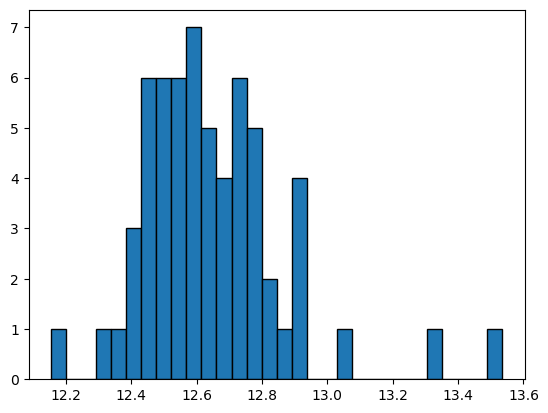

In [163]:
plt.hist((np.log(df_predictions.loc[df_predictions.Neighborhood == 'NoRidge'].SalePrice)), bins=30, edgecolor='black')


In [169]:
result = df_predictions.groupby('Neighborhood')['OverallQual'].agg(lambda x: x.max() - x.min())
sorted_result = result.sort_values(ascending=False)

print(sorted_result)

Neighborhood
OldTown    96
Edwards    80
CollgCr    65
Gilbert    65
Somerst    64
NridgHt    64
Mitchel    63
Timber     56
NAmes      55
NoRidge    51
BrkSide    48
ClearCr    48
Crawfor    48
SawyerW    48
Sawyer     45
SWISU      45
Veenker    45
IDOTRR     45
NWAmes     39
StoneBr    32
Blueste    28
MeadowV    20
Blmngtn    15
NPkVill    13
BrDale     11
Greens      0
Name: OverallQual, dtype: int64


In [167]:
result = df_predictions.groupby('Neighborhood')['SalePrice'].agg(lambda x: x.max() - x.min())
sorted_result = result.sort_values(ascending=False)

print(sorted_result)

Neighborhood
NoRidge    565000
NridgHt    461000
OldTown    430000
StoneBr    340000
Somerst    329000
Crawfor    290650
NAmes      277000
Timber     275000
Gilbert    262500
Edwards    261500
SawyerW    240600
Veenker    222500
CollgCr    222000
Mitchel    218500
ClearCr    194500
NWAmes     179000
BrkSide    175200
IDOTRR     172300
Sawyer     155100
SWISU      137000
Blmngtn     87095
Blueste     85000
MeadowV     78400
Greens      59000
BrDale      42500
NPkVill     35000
Name: SalePrice, dtype: int64


In [165]:
df_predictions.groupby('Neighborhood')

In [149]:
import plotly.graph_objs as go

# Sort the data by shap_values_df_lasso_comb.Neighborhood
sorted_indices = shap_values_df_lasso_log.Neighborhood.argsort()
sorted_neighborhoods = X.Neighborhood[sorted_indices]
sorted_shap_values_lasso = shap_values_df_lasso_log.Neighborhood[sorted_indices]
sorted_shap_values_xgb = shap_values_df_xgb_log.Neighborhood[sorted_indices]

# Create traces
trace1 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_xgb,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()



In [182]:
df_predictions.loc[df_predictions.SalePrice > 400000]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
25    528106110       2046     450000          20       RL   105.000000   
51    528164060       2470     615000          20       RL   106.000000   
80    528441090       2490     468000          20       RL    85.000000   
241   528114010       1868     415000          20       RL   120.000000   
455   921128050       1978     425000          20       RL    85.000000   
494   528327010       2855     405000          60       RL    73.106784   
570   528118040       2758     418000          60       RL   118.000000   
647   528108130       2020     404000          20       RL    95.000000   
771   528166120       2668     412500          60       RL   110.000000   
807   528351010       4316     755000          60       RL   104.000000   
908   528106020       2402     555000          20       RL   105.000000   
940   528102140       2772     462000          60       RL   110.000000   
942   528321010       2794     403000          60       RL   174.000000   
973   528390100       2448     402000          60       RL    52.000000   
1108  528340030       3078     410000          60       RL    89.000000   
1116  528320060       3627     625000          60       RL   118.000000   
1418  528110020       2674     610000          20       RL   105.000000   
1506  528327060       2633     466500          20       RL    90.265064   
1777  902400110       3608     475000          75       RM    90.000000   
1897  528118090       2790     460000          60       RL    96.000000   
1961  528166090       2452     445000          20       RL   110.000000   
2072  916382100       2036     410000          20       RL   113.000000   
2129  527256120       2000     470000          20       RL    90.000000   
2251  528110010       2296     451950          60       RL    97.000000   

      LotArea Street  Alley  LotShape  ...  Fence  MoSold YrSold  SaleType  \
25      15431   Pave    0.0         1  ...     NO       8   2007       WD    
51      12720   Pave    0.0         1  ...     NO       2   2008       WD    
80      11128   Pave    0.0         1  ...  GdPrv      10   2009       WD    
241     14780   Pave    0.0         2  ...     NO       6   2006       WD    
455     12633   Pave    0.0         2  ...     NO       5   2009       WD    
494      9233   Pave    0.0         2  ...     NO       3   2006       WD    
570     13654   Pave    0.0         2  ...     NO       5   2007       WD    
647     12350   Pave    0.0         1  ...     NO       5   2009       WD    
771     13688   Pave    0.0         2  ...     NO       3   2008       WD    
807     21535   Pave    0.0         2  ...     NO       1   2007       WD    
908     15431   Pave    0.0         1  ...     NO       4   2009       WD    
940     14257   Pave    0.0         1  ...     NO       6   2009       WD    
942     15138   Pave    0.0         2  ...     NO       7   2009       WD    
973     46589   Pave    0.0         3  ...     NO       7   2009       WD    
1108    10557   Pave    0.0         2  ...     NO       7   2007       WD    
1116    35760   Pave    0.0         2  ...     NO       7   2006       WD    
1418    13693   Pave    0.0         1  ...     NO       3   2009       WD    
1506    11400   Pave    0.0         1  ...     NO       3   2007       WD    
1777    22950   Pave    0.0         3  ...  GdPrv       6   2006       WD    
1897    12539   Pave    0.0         1  ...     NO       6   2008       WD    
1961    15274   Pave    0.0         2  ...  MnPrv       7   2009       WD    
2072    13438   Pave    0.0         2  ...     NO       7   2009       WD    
2129    18261   Pave    0.0         2  ...     NO       9   2006       WD    
2251    13478   Pave    0.0         2  ...     NO       6   2009     ConLI   

     SaleCondition Bathrooms          Lasso   error_Lasso           xgb  \
25          Normal       3.5  448008.847871   1991.152129  475201.43750   
51          Normal       3.5  55066

In [504]:
shap_5 =  shap_values_df_lasso_log.iloc[700].reindex(shap_values_df_lasso_log.iloc[700].abs().sort_values().index)

In [421]:
shap_5

SaleCondition    0.000000
GarageQual       0.000000
PoolQC           0.000000
SaleType         0.000000
HalfBath        -0.000000
                   ...   
Neighborhood    -0.043419
OverallQual      0.065877
TotalBsmtSF     -0.069785
YearBuilt        0.069959
GrLivArea        0.139974
Name: 5, Length: 78, dtype: float64

In [505]:
labels = shap_5.index.tolist()

# Get the numbers
numbers = shap_5.values.tolist()

# Print the results
print("Labels:", labels)
print("Numbers:", numbers)

Labels: ['SaleCondition', 'PoolQC', '2ndFlrSF', 'RoofMatl', 'LowQualFinSF', 'FullBath', 'ExterCond', 'HalfBath', 'Condition2', 'BsmtUnfSF', 'SaleType', 'Heating', 'GarageYN', 'LandSlope', 'Utilities', 'Street', 'PoolYN', 'GarageQual', 'MSSubClass', 'Electrical', 'RoofStyle', 'LandContour', 'BsmtCond', 'Alley', 'BsmtHalfBath', 'MoSold', 'BsmtFinType2', 'WoodDeckSF', 'Fence', 'KitchenAbvGr', 'Exterior1st', 'LotShape', '3SsnPorch', 'YrSold', 'LotConfig', 'GarageCond', 'Exterior2nd', 'MasVnrType', 'Functional', 'BedroomAbvGr', 'MasVnrArea', 'CentralAir', 'BsmtFinSF2', '1stFlrSF', 'BsmtFullBath', 'BsmtQual', 'PavedDrive', 'Bathrooms', 'ScreenPorch', 'HouseStyle', 'TotRmsAbvGrd', 'EnclosedPorch', 'GarageFinish', 'Fireplaces', 'MSZoning', 'LotFrontage', 'GarageType', 'Condition1', 'OpenPorchSF', 'ExterQual', 'BsmtExposure', 'BldgType', 'HeatingQC', 'LotArea', 'YearRemodAdd', 'BsmtFinType1', 'Foundation', 'FireplaceQu', 'TotalBsmtSF', 'GarageArea', 'Neighborhood', 'BsmtFinSF1', 'OverallCond', 

In [506]:
bv = shap_values_lass_log.base_values[1]
SHAPs = numbers

changes = []
for shaps in SHAPs:
    changes.append((np.exp(bv + shaps) - np.exp(bv)))
    bv = bv + shaps
                 

In [507]:
df_predictions.iloc[700]

PID                528168040
GrLivArea               2374
SalePrice             285000
MSSubClass                60
MSZoning                  RL
                   ...      
Bathrooms                2.5
Lasso          289672.368932
error_Lasso     -4672.368932
xgb             284320.53125
error_xgb          679.46875
Name: 700, Length: 84, dtype: object

In [508]:
np.exp(shap_values_lass_log.base_values[1]) + np.sum(changes) 

289672.3689321015

In [509]:
df_test = pd.DataFrame({'Label': labels, 'Change': changes})

# Print the DataFrame to verify
print(df_test)

            Label        Change
0   SaleCondition      0.000000
1          PoolQC      0.000000
2        2ndFlrSF      0.000000
3        RoofMatl      0.000000
4    LowQualFinSF      0.000000
..            ...           ...
73     GarageCars   5411.079858
74    KitchenQual   7139.900142
75      YearBuilt  13172.776964
76    OverallQual  28628.934298
77      GrLivArea  66088.133800

[78 rows x 2 columns]


In [510]:
df_test = df_test.set_index('Label').T

In [495]:
order = X_new_order.columns
df_ordered = df_test[order]
df_ordered

Label      GrLivArea  MSSubClass  LotFrontage      LotArea      Alley  \
Change -18940.465211         0.0   605.824987 -2274.454955 -16.558486   

Label    LotShape  LandContour  Utilities  LandSlope  OverallQual  ...  \
Change -70.598608    -6.003326        0.0        0.0   662.163182  ...   

Label    Foundation  Heating  CentralAir  Electrical  GarageType  GarageYN  \
Change -1071.388567      0.0  423.587346         0.0  -872.43983       0.0   

Label   PoolYN      Fence  SaleType  SaleCondition  
Change     0.0  52.045112       0.0            0.0  

[1 rows x 78 columns]

In [485]:
df_ordered.iloc[0]

Label
GrLivArea        23860.39599
MSSubClass               0.0
LotFrontage       541.393187
LotArea         -3029.057632
Alley             -16.559404
                    ...     
GarageYN                 0.0
PoolYN                   0.0
Fence              52.028935
SaleType                 0.0
SaleCondition            0.0
Name: Change, Length: 78, dtype: object

In [488]:
df_ordered.loc[3] = df_ordered.iloc[0]
df_ordered

Label     GrLivArea  MSSubClass  LotFrontage      LotArea      Alley  \
Change  23860.39599         0.0   541.393187 -3029.057632 -16.559404   
-1      23860.39599         0.0   541.393187 -3029.057632 -16.559404   
3       23860.39599         0.0   541.393187 -3029.057632 -16.559404   

Label    LotShape  LandContour  Utilities  LandSlope   OverallQual  ...  \
Change -70.607356    -6.003326        0.0        0.0  10123.017389  ...   
-1     -70.607356    -6.003326        0.0        0.0  10123.017389  ...   
3      -70.607356    -6.003326        0.0        0.0  10123.017389  ...   

Label    Foundation  Heating  CentralAir  Electrical  GarageType  GarageYN  \
Change -1103.030871      0.0  424.177939         0.0 -875.850099       0.0   
-1     -1103.030871      0.0  424.177939         0.0 -875.850099       0.0   
3      -1103.030871      0.0  424.177939         0.0 -875.850099       0.0   

Label   PoolYN      Fence  SaleType  SaleCondition  
Change     0.0  52.028935       0.0            0.0  
-1         0.0  52.028935       0.0            0.0  
3          0.0  52.028935       0.0            0.0  

[3 rows x 78 columns]

In [480]:
list_test = X_new_order.iloc[5]
list_test

GrLivArea          1922
MSSubClass           85
LotFrontage        64.0
LotArea            7301
Alley               0.0
                  ...  
GarageYN            yes
PoolYN               no
Fence                NO
SaleType          ConLD
SaleCondition    Normal
Name: 5, Length: 78, dtype: object

In [484]:
df_ordered.loc[-1] = list_test
df_ordered

Label     GrLivArea  MSSubClass  LotFrontage      LotArea      Alley  \
Change  23860.39599         0.0   541.393187 -3029.057632 -16.559404   
-1       1922.00000        85.0    64.000000  7301.000000   0.000000   

Label    LotShape  LandContour  Utilities  LandSlope   OverallQual  ...  \
Change -70.607356    -6.003326        0.0        0.0  10123.017389  ...   
-1       1.000000     4.000000        4.0        3.0     49.000000  ...   

Label    Foundation  Heating  CentralAir  Electrical  GarageType  GarageYN  \
Change -1103.030871      0.0  424.177939         0.0 -875.850099       0.0   
-1             Slab     GasA           Y       SBrkr     BuiltIn       yes   

Label   PoolYN      Fence  SaleType  SaleCondition  
Change     0.0  52.028935       0.0            0.0  
-1          no         NO     ConLD         Normal  

[2 rows x 78 columns]

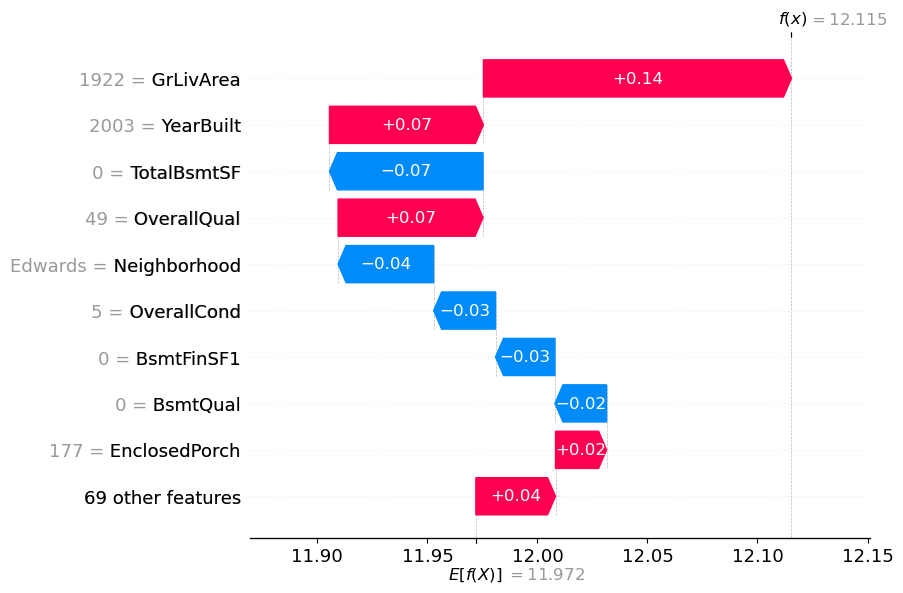

In [429]:
shap.waterfall_plot(exp_lasso_log[5], max_display=10)

In [ ]:
observations = range(2333)
dollar_shap_df = pd.DataFrame(columns=X_new_order.columns)
order = X_new_order.columns

for observation in observations:
    shap_values = shap_values_df_lasso_log.iloc[observation].reindex(shap_values_df_lasso_log.iloc[observation].abs().sort_values().index)
    features = shap_values.index.tolist()
    values = shap_values.values.tolist()
    bv = shap_values_lass_log.base_values[1]
    SHAPs = values
    changes = []
    
    for shaps in SHAPs:
        changes.append((np.exp(bv + shaps) - np.exp(bv)))
        bv = bv + shaps 
        
    df_test = pd.DataFrame({'Feature': features, 'Change': changes})
    df_test = df_test.set_index('Feature').T
    df_ordered = df_test[order]
    dollar_shap_df.loc[observation] = df_ordered.iloc[0]

dollar_shap_df


In [363]:
df_predictions.Lasso[5]

182671.23135241846

In [343]:
np.exp(12.115)

182590.27733054178

In [267]:
bv = 10
SHAPs = [.1, .3, .4, (-.1)]
for shaps in SHAPs:
    new_value = np.exp(bv + shap)
    change = (np.exp(bv + shaps) - np.exp(bv))
    bv = bv + shaps
    print(bv)
    print(change)
    print(new_value)
    print('                  ')
   

10.1
2316.5436296016633
24343.00942440838
                  
10.4
8516.616250034946
32859.62567444333
                  
10.8
16161.175461938423
49020.80113638175
                  
10.700000000000001
-4664.946006083832
44355.85513029792
                  


In [330]:
import plotly.graph_objs as go

# Sort the data by shap_values_df_lasso_comb.Neighborhood
sorted_indices = shap_values_df_lasso_comb.Neighborhood.argsort()
sorted_neighborhoods = X.Neighborhood[sorted_indices]
sorted_shap_values_lasso = shap_values_df_lasso_comb.Neighborhood[sorted_indices]
sorted_shap_values_xgb = shap_values_df_xgb_ohe_comb.Neighborhood[sorted_indices]

# Create traces
trace1 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_xgb,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()



In [35]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.OverallQual,
    y=shap_values_df_xgb_log.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= shap_values_df_lasso_log.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [36]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.OverallQual,
    y=shap_values_df_xgb_ohe_comb.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= shap_values_df_lasso_comb.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [38]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.Condition1,
    y=shap_values_df_xgb_ohe_comb.Condition1,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.Condition1,
    y= shap_values_df_lasso_comb.Condition1,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [37]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_ohe_comb.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= shap_values_df_lasso_comb.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [46]:
fig = px.scatter(
    x=shap_values_df_xgb_ohe_comb.GrLivArea,
    y=shap_values_df_xgb_ohe_comb.OverallQual,
    color=np.sqrt(X.OverallQual), 
     title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
)


fig = px.scatter(
    x=shap_values_df_xgb_log.GrLivArea,
    y=shap_values_df_xgb_log.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
)

fig.show()

In [55]:
import plotly.express as px
from plotly.subplots import make_subplots

# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Dollars", "Log Dollars"))

# First scatter plot
scatter1 = px.scatter(
    x=shap_values_df_xgb_ohe_comb.GrLivArea,
    y=shap_values_df_xgb_ohe_comb.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

# Second scatter plot
scatter2 = px.scatter(
    x=shap_values_df_xgb_log.GrLivArea,
    y=shap_values_df_xgb_log.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

# Add scatter plots to the subplot
for trace in scatter1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in scatter2.data:
    fig.add_trace(trace, row=1, col=2)

# Update layout
fig.update_layout(title_text="Comparison of SHAP for XGB Dollars vs. Log Dollars")

# Show the plot
fig.show()


In [45]:
# fig = px.scatter(
#     x=shap_values_df_lasso_comb.GrLivArea,
#     y=shap_values_df_lasso_comb.OverallQual,
#     color=np.sqrt(X.OverallQual), 
#      title='Living Area SHAP vs. Overall Quality SHAP',
#     color_continuous_scale='Turbo'
# )

fig = px.scatter(
    x=shap_values_df_lasso_log.GrLivArea,
    y=shap_values_df_lasso_log.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
)

fig.show()

In [ ]:
shap_values_df_xgb

In [89]:
shap_values_df_lasso_log.LotArea

0      -0.014794
1      -0.036493
2      -0.025658
3      -0.013274
4      -0.011766
          ...   
2328   -0.009070
2329    0.019581
2330   -0.024411
2331   -0.009237
2332   -0.004915
Name: LotArea, Length: 2333, dtype: float64

In [525]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.LotArea,
    y= shap_values_df_lasso_log.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values (log transformed)',
    xaxis=dict(title='Lot (square feet)'),
    yaxis=dict(title='SHAP Values (log $)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

NameError: name 'shap_values_df_xgb' is not defined

In [72]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb_ohe_comb.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=X.LotArea,
    y= shap_values_df_lasso_comb.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values',
    xaxis=dict(title='Lot (square feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [73]:
import plotly.graph_objs as go

trace1 = go.Scatter(
    x=X.GarageCars,
    y=shap_values_df_xgb_ohe_comb.GarageCars,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GarageCars,
    y= shap_values_df_lasso_comb.GarageCars,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Garage Cars SHAP Values',
    xaxis=dict(title='Cars'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [66]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)


lasso = Lasso(alpha = 0.00030733929099045147)

X_pre = preprocessor.fit_transform(X)

y_log = np.log(y)

lasso.fit(X_pre, y_log)

predict_ = np.exp(lasso.predict(X_pre))
                           
# scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

# print('Lasso')
# print('score', scores.mean())
# print('standard deviation', scores.std())

# lasso_pipe.fit(X,y)

# lasso_predictions = lasso_pipe.predict(X)
# print('predicted prices', lasso_predictions)

# lasso_mae = mean_absolute_error(y, lasso_predictions)
# print('Mean Absolute Error:', lasso_mae)

# lasso_mpv = lasso_predictions.mean()
# print ('Mean Predicted Home Value', lasso_mpv)

# mhv = y.mean()
# print ('Mean  Home Value', mhv)


In [69]:
lasso.fit(X_pre, y)

explainer = shap.Explainer(lasso, masker = X_pre)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_pre)

shap_values
# # Get feature names after transformation
# transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# # Convert SHAP values and transformed data to DataFrame for easier manipulation
# # transform Explanation type into a df with named columns 
# shap_values_df_lasso = pd.DataFrame(shap_values_lasso.values, columns=transformed_feature_names)

# bv = shap_values_lasso.base_values[0]
# dollar_shap_values_lasso = np.exp(bv + shap_values_df_lasso) - np.exp(bv)
    
# # Get rid of prefixes
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('robust_scaler__', 
#                                                                     '', 
#                                                                     regex=False)
# dollar_shap_values_lasso.columns = dollar_shap_values_lasso.columns.str.replace('one-hot-encoder__', 
#                                                                     '', 
#                                                                     regex=False)

# df_lasso = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X))
# df_lasso.columns = dollar_shap_values_lasso.columns
# df_lasso[numerical_columns] = X[numerical_columns]
# df_lasso
# # Create a shap.Explanation with scaled shap values and correct feature names 
# exp_all_lasso = shap.Explanation(dollar_shap_values_lasso.values, 
#                        np.exp(shap_values_lasso.base_values),
#                        df_lasso)

.values =
array([[-4.72361840e+04,  2.89193714e+03,  9.16224391e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [-3.01728773e+04, -6.25654590e+03,  2.36663850e+03, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [-3.44166012e+04,  2.89193714e+03,  1.09141997e+03, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       ...,
       [ 5.40827253e+04, -3.20705156e+03, -4.67180445e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [ 3.99369788e+04, -1.57557208e+02,  3.91171810e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00],
       [ 4.60373319e+04, -1.57557208e+02, -3.25489498e+02, ...,
        -0.00000000e+00, -2.43505078e+00,  0.00000000e+00]])

.base_values =
array([167601.10881636, 167601.10881636, 167601.10881636, ...,
       167601.10881636, 167601.10881636, 167601.10881636])

.data =
array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        , 

In [59]:
np.exp(11.97202774)

158265.25603431257

In [74]:
xgb_pipe_OHE.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb = explainer(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_xgb_df = pd.DataFrame(shap_values_xgb.values, columns=transformed_feature_names)
    
# Get rid of prefixes
shap_xgb_df.columns = shap_xgb_df.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_xgb_df.columns = shap_xgb_df.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

# Create explanation varaible using SHAP values, base values, and original values 
# test = shap.Explanation(shap_values_df_xgb_ohe.values, 
#                        shap_values_xgb_ohe.base_values,
#                        df_lasso)

# shap.summary_plot(exp_all_xgb_ohe, max_display= 20)

 97%|=================== | 2273/2333 [00:24<00:00]       

In [75]:
shap_values_xgb.base_values

array([11.9667094, 11.9667094, 11.9667094, ..., 11.9667094, 11.9667094,
       11.9667094])

In [78]:
np.exp(shap_values_xgb.base_values)

array([157425.7816752, 157425.7816752, 157425.7816752, ...,
       157425.7816752, 157425.7816752, 157425.7816752])

In [77]:
shap_values_xgb_o.base_values

array([167562.8383319, 167562.8383319, 167562.8383319, ...,
       167562.8383319, 167562.8383319, 167562.8383319])